### Google Colab notebook for Mask-RCNN

authors: Tuguldur Sukhbold

In [1]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-nzh3j6p5
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-nzh3j6p5
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263917 sha256=5716e75dac9dc02bf06a2bbe5827c694a9ebd5dcc5263575a5f083f6d34e6fce
  Stored in directory: /tmp/pip-ephem-wheel-cache-k734f3si/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


In [3]:
# extract Images and Masks
#
!unzip Circle.zip

Archive:  Circle.zip
   creating: Circle/
   creating: Circle/Images/
  inflating: Circle/Images/hc0002.png  
  inflating: Circle/Images/hc0236.png  
  inflating: Circle/Images/hc0235.png  
  inflating: Circle/Images/hc0195.png  
 extracting: Circle/Images/hc0112.png  
 extracting: Circle/Images/hc0160.png  
 extracting: Circle/Images/hc0017.png  
  inflating: Circle/Images/hc0084.png  
  inflating: Circle/Images/hc0085.png  
 extracting: Circle/Images/hc0052.png  
 extracting: Circle/Images/hc0202.png  
  inflating: Circle/Images/hc0127.png  
 extracting: Circle/Images/hc0295.png  
  inflating: Circle/Images/hc0218.png  
 extracting: Circle/Images/hc0144.png  
 extracting: Circle/Images/hc0254.png  
 extracting: Circle/Images/hc0120.png  
 extracting: Circle/Images/hc0266.png  
 extracting: Circle/Images/hc0165.png  
 extracting: Circle/Images/hc0256.png  
 extracting: Circle/Images/hc0297.png  
  inflating: Circle/Images/hc0278.png  
  inflating: Circle/Images/hc0231.png  
 extractin

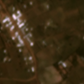

In [5]:
# sample image
from PIL import Image
Image.open('Circle/Images/hc0001.png')

# New Section

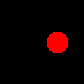

In [7]:
# sample mask (corresponding to the image above)
mask = Image.open('Circle/Masks/hc0001_mask.png')
# adding color palette to the mask to visualize.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [9]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class TrainDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "Masks"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        mask_path = os.path.join(self.root, "Masks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB
        mask = Image.open(mask_path)

        mask = np.array(mask)
        # mask instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [10]:
dataset = TrainDataset('Circle/')
dataset[0]

(<PIL.Image.Image image mode=RGB size=84x84 at 0x7F139DD3EC90>,
 {'area': tensor([36.]),
  'boxes': tensor([[41., 41., 47., 47.]]),
  'image_id': tensor([0]),
  'iscrowd': tensor([0]),
  'labels': tensor([1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [12]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 25136, done.
remote: Counting objects: 100% (2607/2607), done.
remote: Compressing objects: 100% (719/719), done.
remote: Total 25136 (delta 1930), reused 2455 (delta 1838), pack-reused 22529
Receiving objects: 100% (25136/25136), 34.46 MiB | 25.93 MiB/s, done.
Resolving deltas: 100% (18617/18617), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [13]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [14]:
# use our dataset and defined transformations
dataset = TrainDataset('Circle', get_transform(train=True))
dataset_test = TrainDataset('Circle', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-10])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
#device = torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

device

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


device(type='cuda')

In [16]:
# let's train it for 100 epochs
num_epochs = 100

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Streaming output truncated to the last 5000 lines.
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.060
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.110
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
IoU metric: segm
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.008
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.002
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

In [17]:
len(dataset_test)

10

In [95]:
i=5

# pick one image from the test set
img, _ = dataset_test[i]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

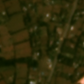

In [96]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

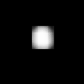

In [97]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

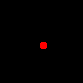

In [98]:
# sample mask (corresponding to the image above)
mask = Image.open(f'Circle/Masks/hc{i:04d}_mask.png')
# adding color palette to the mask to visualize.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [86]:
PATH='circle_ep100_small.pth'
torch.save(model.state_dict(), PATH)